In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


C:\Users\gaurr\AppData\Local\Temp\ipykernel_25964\2658766297.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
import os
from collections import Counter
import pg_fitter_tools_new as fit
import sk_geo_tools as sk
import pandas as pd

In [4]:
# %matplotlib inline
import matplotlib
matplotlib.use('Qt5Agg')
plt.ion()

## Camera Settings

In [5]:
# model from 1 set of 100 image calibration in OpenCV
# fx, fy, cx, cy, k1, k2, k3, p1, p2 = 4.73809110e+03, 4.65803419e+03, 1.99925731e+03, 1.50215594e+03, -1.23429746e-01, -9.18241636e-01, 3.71519697e+00, -3.22955511e-03,  3.95755028e-03


# MATLAB model for old drone calibration
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 3.110658147486340e3, 3.112767335937938e3, 1.988185484316302e3, 1.510529274581101e3, -0.249726265925380, 0.169266475568445, 0, -9.742616359765806e-4, -8.761093588533360e-4, -6.8332

# MATLAB model for new drone calibration
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2953.0, 2959.8, 1944, 1579.7, -0.2645, 0.1855, -0.0344, 2.0412e-4, 8.6272e-4, -8.5083

# OpenCV bootstrapping result
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2768.853929, 2776.554415, 1988.764457, 1558.453228, -0.25680561, 0.15688786, -0.064053488, -0.00041878386, 0.000605649469, 0

# Model used by Nick in 24 PMT and ring reconstruction
fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2.760529621789217e3, 2.767014510543478e3, 1.914303537872458e3, 1.596386868474348e3, -0.2398, 0.1145, 0, 0, 0, 0

focal_length = np.array([fx, fy])
principle_point = np.array([cx, cy])
radial_distortion = np.array([k1, k2, k3])
tangential_distortion = np.array([p1, p2])
# skew = 0

## Load data from files
* Load all PMT locations
* Load image feature locations

In [ ]:
all_pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt") ## cylindrical seed geometry
# all_pmt_locations = fit.read_3d_feature_locations("parameters/dat/pmt_sm_position_polygon.txt", poly=True) ## polyhedron seed geometry
offset = np.array([0, 250])


In [6]:
# plot the PMT locations. The first value in each key is the SM ID, the second, third and fourth are the x, y, z coordinates respectively when usin polyhedron seed geometry

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
pmt_array = np.stack(list(all_pmt_locations.values()))

ax.scatter(pmt_array[:,1], pmt_array[:,2], pmt_array[:,3], marker='.', label="PMT locations")

plt.legend(loc=0)
plt.xlabel("x [cm]", fontsize=12)
plt.ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Seed Positions for the Super-K Detector")
fig.tight_layout()


In [7]:
# path = 'source/LI_points/' # GUI feature detection and labeling
path = 'BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/' # 24 PMT manual feature detection and labeling

image_feature_locations = {}

# pass all of the text files in path to read_image_feature_locations
for file in os.listdir(path):
    if file.endswith(".txt"):
        image_feature_locations.update(fit.read_image_feature_locations(path+file, offset=offset))


In [8]:
# swap out -25 and -00 for features in images where both exist
for im in image_feature_locations.values():
    for feat, loc in im.items():
        if feat[-2:] == "00" and feat[:-2]+"25" in im:
            tmp = loc
            im[feat] = im[feat[:-2]+"25"]
            im[feat[:-2]+"25"] = tmp

In [8]:
# For comparisons with 24 PMT manual labeling study

# look through image_feature_locations and keep only the keys with the following values '1045', '1046', '1047', '1048', '1086', '1087', '1124', '1125', '1126', '1127', '1236', '1237', '1238', '1239', '1240'
image_feature_locations = {k: v for k, v in image_feature_locations.items() if k in ['1045', '1046', '1047', '1048', '1086', '1087', '1236', '1237', '1238', '1239', '1240']}

# go through each image in image_feature_locations. If the feature does not begin with '00810', '00809', '00808', '00807', '00759', '00758', '00757', '00708', '00707', '00706', '00657', '00656', '00655', '00606', '00605', '00604', '00555', '00554', '00553', '00504', '00503', '00502', '00453', '00452', or '00451', remove it from the image
for im in image_feature_locations.values():
    for feat in list(im):
        if feat[:5] not in ['00810', '00809', '00808', '00759', '00758', '00757', '00708', '00707', '00706', '00657', '00656', '00655', '00606', '00605', '00604', '00555', '00554', '00553', '00504', '00503', '00502', '00453', '00452', '00451']:
            del im[feat]


In [9]:
# choose features that appear in 2+
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}

print("The number of features that appear in 2+ images is", len(common_features))

The number of features that appear in 2+ images is 1015


In [11]:
# BOLT LOCATIONS FOR POLYHEDRON SEED GEOMETRY

pmt_locations, sm_pmt_locations, sm_planes, bolt_locations = sk.get_bolt_locations_poly(pmt_locations) # sm_pmt_locations also contains the SM ID in a dataframe. Variable types: dict, df, df, dict

The supermodule plane coefficients are:                a         b             c            d
SM_ID                                               
217.0 -0.921854 -0.387537 -1.146829e-17 -1684.074516
218.0 -0.844341 -0.535806  3.930815e-18 -1684.073277
PMT ID:  00451-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438917e-18  1.00000000e+00] [-0.38753725  0.92185405  0.        ]
PMT ID:  00452-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438917e-18  1.00000000e+00] [-0.38753725  0.92185405  0.        ]
PMT ID:  00453-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438917e-18  1.00000000e+00] [-0.38753725  0.92185405  0.        ]
PMT ID:  00502-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438917e-18  1.00000000e+00] [-0.38753725  0.92185405  0.        ]
PMT ID:  00503-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438917e-18  1.00000000e+00] [-0.38753725  0.92185405  0.        ]
PMT ID:  00504-00
SM ID:  217.0
v1 and v2 are  [-1.05720887e-17 -4.44438

In [10]:
# BOLT LOCATIONS FOR CYLINDRICAL SEED GEOMETRY

bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)

In [11]:
common_bolt_locations = {k: b for k, b in bolt_locations.items() if k in common_features}

common_feature_locations = {**pmt_locations, **bolt_locations}

common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}

common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}

common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in bolt_locations}
    for k, i in image_feature_locations.items()}


nimages = len(common_image_feature_locations) # number of images with common features
nfeatures = len(common_feature_locations) # number of features that appear in at least 2 images (bolts and PMTs)

print("The number of images and common features is", nimages, nfeatures)


The number of images and common features is 11 600


## Plot seed positions for PMTs and bolts

In [13]:
# PLOTTING FOR POLYHEDRON SEED GEOMETRY

sk.plot_seed_poly(sm_pmt_locations, sm_planes, bolt_locations, top=False) # choose whether or not to generate top view plot

In [12]:
# PLOTTING FOR CYLINDRICAL SEED GEOMETRY

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="Bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="PMT (seed position)")
# for i, f in enumerate(pmt_locations.keys()):
#     ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=8, zorder=4, color='k') 
plt.legend(loc=0)
fig.tight_layout()

ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Seed Positions")

# rotate the plot
ax.view_init(0, 210)
plt.show()

In [13]:
# top view of seed positions

fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="Bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="PMT (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_title("Seed Positions (Top View)")
fig.tight_layout()

## Create fitter objects from PhotogrammetryFitter class

In [29]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)


11 images with total of  24 features
11 images with total of  575 features
11 images with total of  599 features



## Estimate camera poses assuming seed feature positions

In [15]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average:3.815062607328776   max: 15.641593515345667
image 1 reprojection errors:    average:4.533567223316755   max: 14.913212046153504
image 2 reprojection errors:    average:4.321208830231833   max: 16.718808134952532
image 3 reprojection errors:    average:4.495039171236143   max: 19.178706840482302
image 4 reprojection errors:    average:3.2586080752635382   max: 13.0759608796614
image 5 reprojection errors:    average:2.948519413810837   max: 8.920609148637038
image 6 reprojection errors:    average:4.061302264415798   max: 14.776616141163915
image 7 reprojection errors:    average:3.450554259512819   max: 11.264626753208509
image 8 reprojection errors:    average:3.1709937591434687   max: 12.421395777509803
image 9 reprojection errors:    average:2.8685487358712045   max: 8.789097469590068
image 10 reprojection errors:    average:2.893899424374926   max: 9.571159655791003


### Plot overlay of reprojected and observed feature locations for manual checking

In [247]:
## Plotting reprojected points for selected image from df_reprojected
test_image = 1 # image_id
fig, ax = plt.subplots(figsize=(12,9))
coords = np.stack(list(common_image_feature_locations[fitter_pmts.index_image[test_image]].values()))
# get corresponding reprojected points from df_reprojected
repro_coords = np.stack(list(df_reprojected[df_reprojected['image_id'] == fitter_pmts.index_image[test_image]][['x', 'y']].values))
ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')

for t, f in common_image_feature_locations[fitter_pmts.index_image[test_image]].items(): #
    # print only PMT labels, those that end with "00"
    if t[-2:] == "00":
        ax.text(f[0], 3000-f[1], t, size=9, zorder=4, color='k')

for t, f in df_reprojected[df_reprojected['image_id'] == fitter_pmts.index_image[test_image]].iterrows():
    if f['feature_id'][-2:] == "00":
        ax.text(f['x'], 3000-f['y'], f['feature_id'], size=9, zorder=4, color='green')

ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
ax.set_ylim(0, 3000)
ax.set_xlim(0, 4000)
plt.legend(loc=0)

plt.show()


### Plot camera position estimates in 3D

In [16]:
## Fit camera positions
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)

In [17]:
## Plotting camera position estimates
sk.plot_cam_poses(pmt_locations, common_feature_locations, camera_positions)

### Save camera orientations and positions to text files

In [40]:
# change the shape of camera_orientations from 3D array to 1D array
camera_orientations = camera_orientations.reshape((camera_orientations.shape[0], 9))
camera_positions = camera_positions.reshape((camera_positions.shape[0], 3))

# save camera_orientations to text file called "cylindrical_camera_orientations.txt" and put it in the 'results/24_PMT_Results/Cylindrical_Seed_Results/' folder; add a column in the beginning with the image name
np.savetxt('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_camera_orientations.txt', np.hstack((np.array([fitter_all.index_image[i] for i in range(len(fitter_all.index_image))]).reshape((len(fitter_all.index_image), 1)), camera_orientations)), fmt='%s', delimiter='\t')

# save camera_positions to text file called "cylindrical_camera_positions.txt" and put it in the 'results/24_PMT_Results/Cylindrical_Seed_Results/' folder; add a column in the beginning with the image name
np.savetxt('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_camera_positions.txt', np.hstack((np.array([fitter_all.index_image[i] for i in range(len(fitter_all.index_image))]).reshape((len(fitter_all.index_image), 1)), camera_positions)), fmt='%s', delimiter='\t')


## Perform bundle asjustment starting from seed geometry and estimated camera poses

In [34]:
for i in range(20):
    camera_rotations, camera_translations, reco_locations, opt = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True, fit_cam=False, return_opt=True)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5604e+04                                    1.27e+06    
       1              2         1.3493e+04      3.21e+04       2.31e+01       2.06e+04    
       2              3         1.0797e+04      2.70e+03       2.14e+01       3.31e+04    
       3              4         1.0067e+04      7.30e+02       3.39e+00       3.39e+03    
       4              5         1.0044e+04      2.29e+01       3.44e-01       7.05e+03    
       5              6         1.0031e+04      1.28e+01       1.61e-01       6.12e+03    
       6              7         1.0030e+04      1.54e+00       1.57e-02       6.97e+03    
       7              8         1.0029e+04      4.79e-01       1.48e-04       3.99e+01    
       8              9         1.0020e+04      9.49e+00       1.79e-01       2.36e+02    
       9             10         1.0011e+04      8.97e+00       1.21e-01       3.38e+02    

## Extracting Fit Errors & Making Relevant Error Plots

In [ ]:

# offset = 4+fitted_distortion.shape[0]

# convert the entries from opt.jac to dtype float
opt.jac = opt.jac.astype(np.uint8)

J=opt.jac[:,fitter_all.nimages*6:].toarray() # Jacobian matrix for the feature locations
U, s, Vh = linalg.svd(J, full_matrices=False) # singular value decomposition. U and Vh are unitary matrices, s contains J's singular values
tol = np.finfo(float).eps*s[0]*max(J.shape) # tolerance for zero singular values
w = s > tol # indices of nonzero singular values
cov = (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
perr = np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters
feature_location_errors = perr.reshape((-1, 3))

opt.fun.size # number of residuals
opt.x.size # number of parameters
opt.nfev # number of function evaluations
opt.njev # number of jacobian evaluations
perr.size # number of fitted parameters

chi2dof = np.sum(opt.fun**2)/(opt.fun.size - perr.size) # chi2 per degree of freedom
cov_scaled = cov*chi2dof # scaled covariance matrix
perr = np.sqrt(np.diag(cov_scaled))    # 1sigma uncertainty on fitted parameters
feature_location_errors = perr.reshape((-1, 3)) # reshape to match feature locations

In [69]:
print(feature_location_errors)

[[0.0034771  0.00174275 0.0023662 ]
 [0.00481123 0.00219072 0.00259206]
 [0.00347708 0.00174644 0.0023662 ]
 ...
 [0.00439205 0.00218951 0.00289801]
 [1.1771802  0.0104823  0.00193456]
 [0.00347712 0.00174217 0.00236621]]
[1.20901950e-05 2.31479517e-05 1.20900713e-05 1.75901732e-05
 1.20902232e-05 1.70074618e-05 1.44203368e-05 1.37450179e-05
 1.33607773e-05 1.81570558e-05 1.65016882e-05 1.48415211e-05
 1.91158742e-05 1.48547497e-05 1.51425211e-05 1.20902159e-05
 1.37457309e-05 2.20458805e-05 1.65125530e-05 1.31960714e-05
 1.38575387e+00 1.37457682e-05 1.70001567e-05 1.48415093e-05
 1.48417002e-05 1.20902196e-05 1.20902514e-05 1.89038019e-05
 1.37460274e-05 1.31961478e-05 1.37459174e-05 1.38574779e+00
 2.20458569e-05 1.37459147e-05 1.98102462e-05 1.20903260e-05
 1.20901368e-05 1.89057828e-05 1.31960342e-05 1.24714825e-05
 1.58380408e-05 1.44141513e-05 1.20900750e-05 1.62061478e-05
 1.37370872e+00 2.31741978e-05 1.20901923e-05 1.46408975e-05
 1.37459001e-05 1.65016354e-05 1.22394586e-05 

In [36]:

# plot histogram of errors on feature locations
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(feature_location_errors.flatten(), bins=50, histtype="step")
ax.set_xlabel("Fitter error on feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
ax.set_title("Fitter Error on Feature Positions", fontsize=15)

Text(0.5, 1.0, 'Fitter Error on Feature Positions')

In [37]:
# separating out the errors into x, y, z components
x_variance = np.diag(cov_scaled)[0::3]
y_variance = np.diag(cov_scaled)[1::3]
z_variance = np.diag(cov_scaled)[2::3]
variance_3d = x_variance + y_variance + z_variance
xy_covariance = cov_scaled[range(0,cov_scaled.shape[0],3),range(1,cov_scaled.shape[1],3)]
xz_covariance = cov_scaled[range(0,cov_scaled.shape[0],3),range(2,cov_scaled.shape[1],3)]
yz_covariance = cov_scaled[range(1,cov_scaled.shape[0],3),range(2,cov_scaled.shape[1],3)]
radial_positions = linalg.norm(fitter_all.reco_locations[:,:2], axis=1)
x_positions = fitter_all.reco_locations[:,0]
y_positions = fitter_all.reco_locations[:,1]
z_positions = fitter_all.reco_locations[:,2]
radial_variance = ((x_positions**2)*x_variance+(y_positions**2)*y_variance+2*x_positions*y_positions*xy_covariance)/radial_positions**2
tangential_variance = variance_3d-radial_variance

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(x_variance), bins=20, histtype="step", color="r", label=f"x position error\nmean = {np.mean(np.sqrt(x_variance)):.3} cm")
ax.hist(np.sqrt(y_variance), bins=20, histtype="step", color="b", label=f"y position error\nmean = {np.mean(np.sqrt(y_variance)):.3} cm")
ax.hist(np.sqrt(z_variance), bins=20, histtype="step", color="g", label=f"z position error\nmean = {np.mean(np.sqrt(z_variance)):.3} cm")
ax.set_xlabel("Fitter error on feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(variance_3d), bins=20, histtype="step", label=f"3D position error\nmean = {np.mean(np.sqrt(variance_3d)):.3} cm")
ax.set_xlabel("Fitter error on 3D feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})
ax.set_title("Fitter Error on 3D Feature Positions", fontsize=15)

Text(0.5, 1.0, 'Fitter Error on 3D Feature Positions')

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(radial_variance), bins=20, histtype="step", color="b", label=f"Radial position error\nmean = {np.mean(np.sqrt(radial_variance)):.3} cm")
ax.hist(np.sqrt(tangential_variance), bins=20, histtype="step", color="r", label=f"Tangential position error\nmean = {np.mean(np.sqrt(tangential_variance)):.3} cm")
ax.set_xlabel("Fitter error on radial feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})
ax.set_title("Fitter Error on Radial and Tangential Feature Positions", fontsize=15)

Text(0.5, 1.0, 'Fitter Error on Radial and Tangential Feature Positions')

In [61]:
## saving the fitter errors to text files

print(feature_location_errors)

[[0.0034771  0.00174275 0.0023662 ]
 [0.00481123 0.00219072 0.00259206]
 [0.00347708 0.00174644 0.0023662 ]
 ...
 [0.00439205 0.00218951 0.00289801]
 [1.1771802  0.0104823  0.00193456]
 [0.00347712 0.00174217 0.00236621]]


## Save all the fitter errors

In [ ]:

# save the fitter errors to a text file called "newFD_fitter_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_fitter_errors_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(variance_3d).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')

# save the x, y, z, fitter position errors to a text file called "newFD_xyz_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_xyz_errors_matab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(x_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(y_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(z_variance).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')

# save the radial and tangential fitter position errors to a text file called "newFD_radial_tangential_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_radtan_errors_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(radial_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(tangential_variance).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')


## Kabsch algorithm to match reconstructed coordinate system to seed co-ordinate system

In [41]:
df_residuals, df_reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error: ", np.mean(df_residuals['residual']))
print("max reconstruction error: ", np.max(df_residuals['residual']))

mean reconstruction error:  1.3083226682939946
max reconstruction error:  3.8248583113617514


In [42]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

# getting df or reprojection errors (feature_id, image_id, error_x, error_y, RE)
df_res, df_reprojected = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)

## Save Results to Text Files

In [43]:
## REMEMBER TO CHANGE THE FILE PATHS

## reprojected points with feature IDs and image IDs, i.e. save df_reprojected dataframe with column names
df_reprojected.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_reprojected_points.txt', header=True, index=None, sep='\t')

## reprojection errors with feature IDs and image IDs, i.e. df_res
df_res.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_reprojection_errors.txt', header=True, index=None, sep='\t')

## reconstructed 3D feature locations with feature IDs. Same coordinate system as seed geometry, i.e. df_reco_transformed
df_reco_transformed.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_reconstructed_points.txt', header=True, index=None, sep='\t')

## residuals with feature IDs, i.e. df_residuals
df_residuals.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_residuals.txt', header=True, index=None, sep='\t')

## Plots of reconstructed geometry

In [52]:
true_array = np.stack(list(common_feature_locations.values()))


In [71]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
rot_theta = (90-27.261)*np.pi/180
ax.scatter(reco_transformed[:,0]*np.cos(rot_theta)-reco_transformed[:,1]*np.sin(rot_theta), reco_transformed[:,0]*np.sin(rot_theta)+reco_transformed[:,1]*np.cos(rot_theta), marker='.', label="Reconstructed")
ax.scatter(true_array[:,0]*np.cos(rot_theta)-true_array[:,1]*np.sin(rot_theta), true_array[:,0]*np.sin(rot_theta)+true_array[:,1]*np.cos(rot_theta), marker='.', label="Expected", s=100)
#ax.set_ylim((500,1050))
#ax.set_xlim((1320,1600))
# circle = plt.Circle((0, 0), 1690-15, color='black', fill=False)
# ax.add_artist(circle)
# for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlabel("X [cm]", fontsize=12)
ax.set_ylabel("Y [cm]", fontsize=12)
ax.set_title("Reconstructed Positions (Top View)")
plt.legend(loc=0)
fig.tight_layout()

In [75]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="Reconstructed Positions", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="Seed Positions", zorder=2)

for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=8, zorder=4, color='k')

ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="Cameras", zorder=1) # plotting reconstructed camera poses
ax.set_xlabel("X [cm]", fontsize=12)
ax.set_ylabel("Y [cm]", fontsize=12)
ax.set_zlabel("Z [cm]", fontsize=12)
plt.legend(loc=0)
fig.tight_layout()
ax.set_title("Reconstructed Positions (Camera Vie1w)")
# rotate the plot to see the bolt ring
ax.view_init(30, -100)

In [80]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="Reconstructed", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="Expected", zorder=2)
for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k')
    print(f, reco_transformed[i])
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()
ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Reconstructed Feature Positions")
# rotate the plot to see the bolt ring
ax.view_init(20, -120)


00451-00 [1597.60259997  559.80529175 1207.66822235]
00452-00 [1597.92612123  559.62325789 1273.27111221]
00453-00 [1597.40383114  559.75479703 1339.80044206]
00502-00 [1573.13889922  623.20518713 1206.43498342]
00503-00 [1572.75369221  623.3382579  1272.5898474 ]
00504-00 [1572.45753072  623.62321808 1338.7280069 ]
00553-00 [1545.07015851  687.02837541 1206.23551267]
00554-00 [1546.02252099  687.31796967 1272.78128791]
00555-00 [1545.53594315  687.53673909 1339.72802535]
00604-00 [1517.12274752  749.43814448 1206.38991801]
00605-00 [1517.78945602  749.52074343 1272.98396017]
00606-00 [1517.80388708  750.02184153 1339.38077616]
00655-00 [1482.30740366  817.53633497 1206.54718936]
00656-00 [1481.72977208  817.49929242 1273.39724101]
00657-00 [1483.06423721  818.21618452 1339.89268052]
00706-00 [1445.60007651  875.65764482 1205.83111498]
00707-00 [1446.50149046  876.16177983 1272.7804873 ]
00708-00 [1446.18938812  876.41640673 1339.1756646 ]
00757-00 [1409.95739281  936.39752994 1205.963

## Plotting Reprojection Errors and Residuals

In [50]:
## make histograms for reprojection errors and residuals
sk.hist_res(df_res)
sk.hist_residuals(df_residuals)

In [51]:
## Calculating the adjacent bolt distances and the bolt ring radii

bolt_distances = sk.get_bolt_dists_new(df_reco_transformed)
bolt_ring_radii = sk.get_bolt_ring_radii_new(df_reco_transformed)

In [52]:
# plot histograms of bolt distances and bolt ring radii
sk.hist_bolt_dists(bolt_distances)
sk.hist_bolt_ring_radii(bolt_ring_radii)

In [53]:
## Save the bolt distances and bolt radii to text files

## REMEMBER TO CHANGE THE FILE PATHS

# bolt distances with feature IDs, i.e. bolt_distances
bolt_distances.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_bolt_distances.txt', header=True, index=None, sep='\t')

# bolt ring radii with feature IDs, i.e. bolt_ring_radii
bolt_ring_radii.to_csv('results/24_PMT_Results/Cylindrical_Seed_Results/Manual/cylindrical_bolt_ring_radii.txt', header=True, index=None, sep='\t')


In [72]:
#### ONLY HAD TO DO THIS FOR CYLINDRICAL SEED GEOMETRY. OTHERWISE CAN SIMPLY USE SK.FIT_SM_PLANE FUNCTION SINCE IT GROUPS BY SUPERMODULE

# order df_reco_transformed by feature_id
df_reco_transformed = df_reco_transformed.sort_values(by='feature_id')

# use sk.fit_plane to fit a plane to the first half of df_reco_transformed 'x', 'y', 'z' columns
plane1 = sk.fit_plane(df_reco_transformed.iloc[len(df_reco_transformed)//2:][['x', 'y', 'z']])
# use sk.fit_plane to fit a plane to the second half of df_reco_transformed 'x', 'y', 'z' columns
plane2 = sk.fit_plane(df_reco_transformed.iloc[:len(df_reco_transformed)//2][['x', 'y', 'z']])

print("The normal vector of the first plane is: ", plane1)
print("The normal vector of the second plane is: ", plane2)

# calculate the angle between the two planes
angle = np.arccos(np.dot(plane1[:2], plane2[:2]))
print("The angle between the two planes is: ", np.degrees(angle))

The normal vector of the first plane is:  (-0.8436781545725114, -0.5368468838322309, 0.0016108434887414863, -1687.6178702907853)
The normal vector of the second plane is:  (-0.9220122590039912, -0.387153501595745, -0.0023580603279591736, -1692.5716046754462)
The angle between the two planes is:  9.69310022679961


In [ ]:

# normalize the normal vectors in bolt_planes
bolt_planes['a'], bolt_planes['b'], bolt_planes['c'] = bolt_planes['a'] / np.linalg.norm(bolt_planes[['a', 'b', 'c']], axis=1), bolt_planes['b'] / np.linalg.norm(bolt_planes[['a', 'b', 'c']], axis=1), bolt_planes['c'] / np.linalg.norm(bolt_planes[['a', 'b', 'c']], axis=1)

print("The bolt rings' plane coefficients are: ", bolt_planes)

# average the normal vectors for bolt ring planes belonging to the same supermodule i.e. get the mean of the a, b, c values

# average the a, b, c values for the first 12 rows from bolt_planes
mean_normals_1 = bolt_planes.iloc[:12][['a', 'b', 'c']].mean()
# average the a, b, c values for the last 12 rows from bolt_planes
mean_normals_2 = bolt_planes.iloc[12:][['a', 'b', 'c']].mean()

print("The mean normal vectors for the left 12 PMTs are: ", mean_normals_1)
print("The mean normal vectors for the right 12 PMTs are: ", mean_normals_2)

# calculate the angle between the two planes
angle = np.arccos(np.dot(mean_normals_1, mean_normals_2))
print("The angle between the two planes is: ", np.degrees(angle))

In [ ]:

planes = sk.get_bolt_ring_planes(bolt_dict)
# flip planes if they're facing wrong direction (all normals should point towards tank centre)
plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')
NN = 100
for pmt in sk.get_unique_pmt_ids(bolt_dict):
    pmt_bolt_coords = np.array([l for b, l in bolt_dict.items() if b[:5] == pmt])
    icolor = 'b' if int(pmt)>607 else 'orange' 
    ax.scatter(pmt_bolt_coords[:,0], pmt_bolt_coords[:,1], pmt_bolt_coords[:,2], color=icolor)
    p, n = planes[pmt]
    X,Y,Z = [[p[i]-n[i]*NN, p[i]+n[i]*NN] for i in range(3)]
    ax.plot(X,Y,Z,color=icolor)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(1200,1800)
ax.set_ylim(500, 1100)
ax.set_zlim(1000, 1500)
ax.view_init(90, -140)
ax.set_title('Supermodule Planes')

In [34]:
####### calculate the mean normal angles
###### mean normal direction of left 12 and right 12
normals1 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) <= 607])
normals2 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) > 607])
N1 = np.mean(normals1, axis=0)
N2 = np.mean(normals2, axis=0)
print ('norm (avg of 12 angles)', N1, N2)

##### normal for fitting all 12 at once
N1_all = sk.get_supermodule_plane(bolt_dict, 451, 606)[1]
N2_all = sk.get_supermodule_plane(bolt_dict, 655, 810)[1]
print ('norm (simultanous fit 12 PMTs)', N1_all, N2_all)

###### difference
print ('diff (degrees)', np.degrees(np.arccos(np.dot(N1, N1_all))), np.degrees(np.arccos(np.dot(N1, N2_all))))

In [35]:
cos1=np.dot(normals1, N1_all)
cos2=np.dot(normals2, N2_all)
theta1=np.degrees(np.arccos(cos1))
theta2=np.degrees(np.arccos(cos2))
diff_2walls = np.degrees(np.arccos(np.dot(N1_all, N2_all)))

# print (cos1)
# print (cos2)
print ('Angle between 2 walls (using normals fitted to 12 PMTs simultaneously):',diff_2walls)
print (theta1)
print (theta2)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.hist(theta1, histtype='step', bins=10, range=(0,2.3),label='left 12 PMTs')
ax.hist(theta2, histtype='stepfilled', bins=10, range=(0,2.3),label='right 12 PMTs',alpha=0.5)
ax.set_xlabel('Angle from normal (degree)', fontsize=14)
ax.set_title('Angle between 2 groups (degrees):%.2f'%(diff_2walls), fontsize=14)
ax.legend( fontsize=14)
ax.set_ylabel('Number of PMTs', fontsize=14)
ax.set_ylim(0,4)
plt.tight_layout()

In [ ]:
# import text file LI_reconstructed_final_2.txt into pandas dataframe
import pandas as pd

df = pd.read_csv('results/LI_reconstructed_final_2.txt', sep='\t', header=None)
df.columns = ['feature', 'x', 'y', 'z']


In [ ]:
# make pmts_df with only entries which have '00' in the feature name
pmts_df = df[df['feature'].str.contains('00')]

# make column1_df for all entries which have x and y which are within 4cm of pmt_locations['00622-00'][0], pmt_locations['00622-00'][1] respectivelly
column1_df = pmts_df[(pmts_df['x'] > pmt_locations['00622-00'][0]-4) & (pmts_df['x'] < pmt_locations['00622-00'][0]+4) & (pmts_df['y'] > pmt_locations['00622-00'][1]-4) & (pmts_df['y'] < pmt_locations['00622-00'][1]+4)]

# rearrange column1_df to have the entries so the feature label is in ascending order
column1_df = column1_df.sort_values(by='feature')

In [41]:
print(column1_df)

        feature            x           y            z
7351   00613-00  1479.051061  814.753248 -1761.171651
2908   00614-00  1478.541262  815.328332 -1694.023964
4426   00615-00  1477.152666  815.082772 -1627.726948
2011   00616-00  1477.007654  815.642346 -1550.849487
12482  00617-00  1477.608932  815.824599 -1483.956174
1225   00618-00  1476.269987  815.742181 -1416.647760
11531  00619-00  1474.506792  814.722342 -1338.042338
11640  00620-00  1477.008968  815.615820 -1271.589136
8193   00621-00  1477.844300  816.283951 -1204.489907
14531  00622-00  1477.035440  815.753579 -1128.069828
6269   00623-00  1477.880616  816.162292 -1060.454180
6994   00624-00  1479.981189  817.202325  -992.744394
7856   00625-00  1480.891722  817.261502  -914.595368
6574   00626-00  1479.177388  816.807066  -848.078471
488    00627-00  1477.770237  816.022136  -779.464848
13071  00628-00  1477.049690  815.158775  -702.721389
14533  00629-00  1477.675101  815.753237  -636.871608
439    00630-00  1478.772496

[ 1477.66    814.519 -1127.5  ]
1687.2819198228256


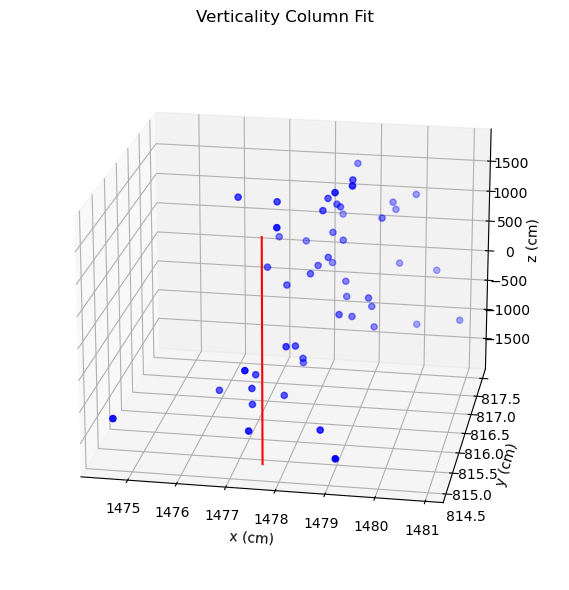

In [54]:
## fitting columns

# get the coordinates for PMT 00622-00 from the seed geometry locations held in true_array
print(pmt_locations['00622-00'])

# calculate radial distance from (0, 0, -1127.5) to the PMT 00622-00
r = linalg.norm(pmt_locations['00622-00'][:2])
print(r)

# at r, make a 3d plot of vertical column from z = [-1500, 1500]
z = np.linspace(-1770, 1770, 100)
x = r*np.cos(np.arctan2(pmt_locations['00622-00'][1], pmt_locations['00622-00'][0]))*np.ones_like(z)
y = r*np.sin(np.arctan2(pmt_locations['00622-00'][1], pmt_locations['00622-00'][0]))*np.ones_like(z)


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Fitted Column', color='r')
# plot column1_df
ax.scatter(column1_df['x'], column1_df['y'], column1_df['z'], label='Reconstructed PMTs', color='b')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')
ax.set_title('Verticality Column Fit')
# rotate the plot by 90 degrees
ax.view_init(20, -80)
plt.tight_layout()
